In [2]:
import pandas as pd


# Loading dataset

In [18]:
df_test = pd.read_csv('data/test.csv')
df_train = pd.read_csv('data/train.csv')


In [19]:
df_train.isnull().sum()   # There is no null values in the dataset
df_test.isnull().sum()   # There is no null values in the dataset


id       0
tweet    0
dtype: int64

In [21]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB


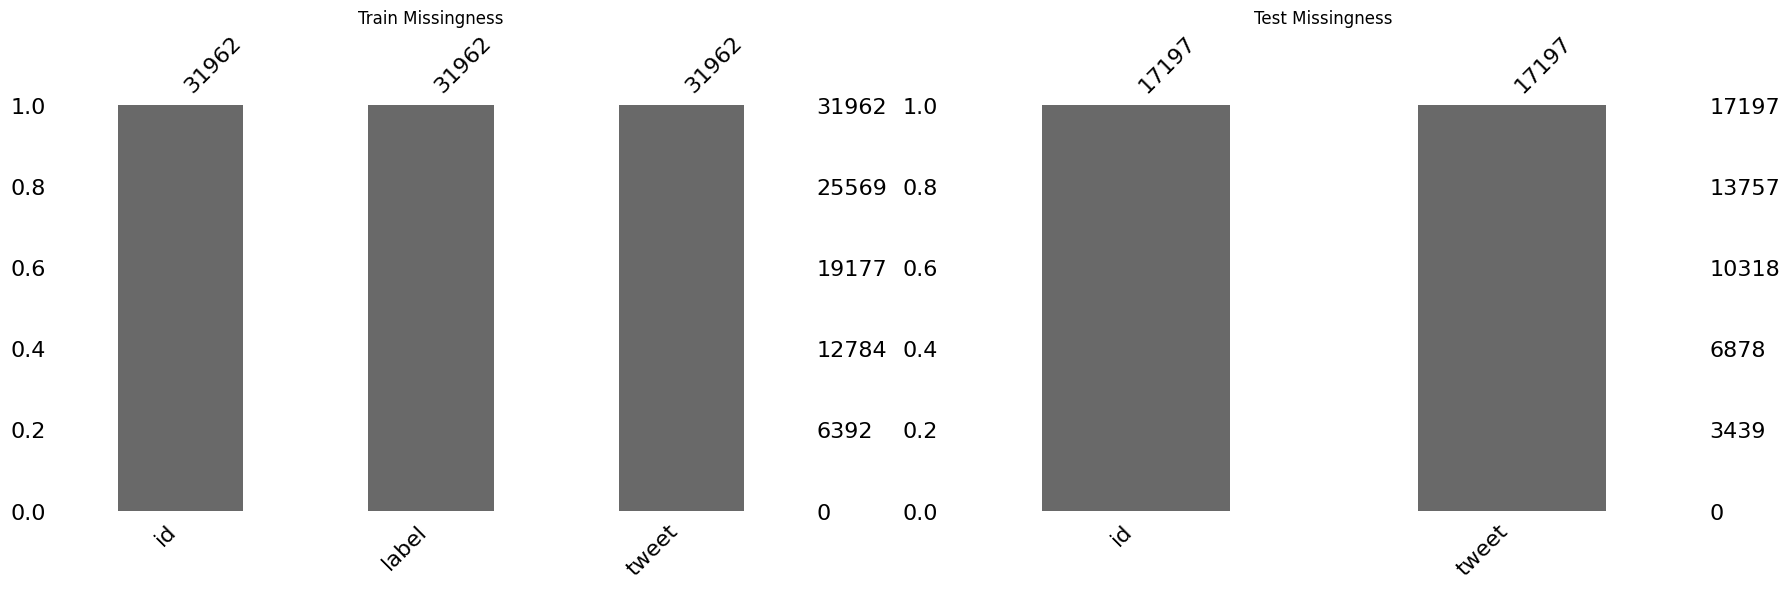

In [26]:
import missingno as msno
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

msno.bar(df_train, ax=axes[0])
axes[0].set_title("Train Missingness")

msno.bar(df_test, ax=axes[1])
axes[1].set_title("Test Missingness")

plt.tight_layout()
plt.show()



# Data preprocessing

1. Remove duplicates

In [ ]:
import re
import pandas as pd

# ==========================================================
# We drop repeated tweets to avoid training the model
# on the same text multiple times, which can bias learning.
# ==========================================================


# ------------------------------
# 1. Remove duplicates in TRAIN
# ------------------------------

# count how many duplicated tweets exist
duplicate_count = df_train.duplicated(subset='tweet').sum()
print("Train duplicates:", duplicate_count)

# remove duplicate tweets, keep only the first appearance
df_train = df_train.drop_duplicates(subset='tweet', keep='first').reset_index(drop=True)

print("New train size:", len(df_train))   # show new dataset size


# ------------------------------
# 2. Remove duplicates in TEST
# ------------------------------

# count duplicated tweets in test set
duplicate_count_test = df_test.duplicated(subset='tweet').sum()
print("Test duplicates:", duplicate_count_test)

# remove duplicates and reset index
df_test = df_test.drop_duplicates(subset='tweet', keep='first').reset_index(drop=True)

print("New test size:", len(df_test))     # show new dataset size


Train duplicates: 0
New train size: 29530
Test duplicates: 0
New test size: 16130


2. Clean tweets

In [ ]:
# ==========================================================
# This block cleans raw tweet text by:
# - converting to lowercase
# - removing URLs, mentions, hashtags
# - removing punctuation, special characters, numbers
# - removing extra spaces
# ==========================================================

def clean_text_column(series):
    cleaned = []

    for text in series:
        text = text.lower()                                     # convert to lowercase
        text = re.sub(r'http\S+|www\S+', '', text)              # remove URLs
        text = re.sub(r'@\w+', '', text)                        # remove @mentions
        text = re.sub(r'#', '', text)                           # remove hashtag symbol (keep word)
        text = re.sub(r'[^a-zA-Z\s]', '', text)                 # remove punctuation, emojis, numbers
        text = re.sub(r'\s+', ' ', text).strip()                # remove extra spaces
        cleaned.append(text)                                    # store the cleaned tweet

    return cleaned


# apply cleaning to TRAIN tweets
df_train["clean_tweet"] = clean_text_column(df_train["tweet"])

# apply cleaning to TEST tweets
df_test["clean_tweet"] = clean_text_column(df_test["tweet"])


3. Remove stopwords

In [ ]:
# ============================================
# We take the cleaned text, remove common words
# like "the", "is", "and" because they add noise
# ============================================

import nltk
from nltk.corpus import stopwords

# download stopwords (only first time)
nltk.download('stopwords')

# load English stopwords into a set for fast lookup
stop_words = set(stopwords.words('english'))


# ----------------------------------------------------
# Remove stopwords from TRAIN dataset
# ----------------------------------------------------
clean_no_stop_train = []

for text in df_train["clean_tweet"]:
    words = text.split()                           # split sentence into list of words
    words = [w for w in words if w not in stop_words]  # filter out stopwords
    text_no_stop = " ".join(words)                 # join back into string
    clean_no_stop_train.append(text_no_stop)

# assign back to dataframe
df_train["clean_tweet"] = clean_no_stop_train


# ----------------------------------------------------
# Remove stopwords from TEST dataset
# ----------------------------------------------------
clean_no_stop_test = []

for text in df_test["clean_tweet"]:
    words = text.split()                           # split into tokens
    words = [w for w in words if w not in stop_words]  # keep non-stopwords
    text_no_stop = " ".join(words)                 # join back
    clean_no_stop_test.append(text_no_stop)

df_test["clean_tweet"] = clean_no_stop_test


[nltk_data] Downloading package stopwords to /home/mehdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


4. Tokenization

In [39]:
# ==========================================================
# We split each cleaned tweet into individual words.
# Example: "i love twitter" → ["i", "love", "twitter"]
# ==========================================================

# -------------------------
# Tokenize TRAIN tweets
# -------------------------
tokenized_train = []          # list to store token lists

for text in df_train["clean_tweet"]:
    tokens = text.split()     # split text by spaces → tokens
    tokenized_train.append(tokens)

df_train["tokens"] = tokenized_train   # save tokens column


# -------------------------
# Tokenize TEST tweets
# -------------------------
tokenized_test = []

for text in df_test["clean_tweet"]:
    tokens = text.split()
    tokenized_test.append(tokens)

df_test["tokens"] = tokenized_test


5. Stemming or lemmatization

In [40]:
# ==========================================================
# Stemming reduces words to their root form:
# "playing", "played" → "play"
# This helps models generalize better.
# ==========================================================

import nltk
from nltk.stem import PorterStemmer

# download (only needed once)
nltk.download('punkt')

stemmer = PorterStemmer()


# -------------------------
# Stem TRAIN tokens
# -------------------------
stemmed_train = []

for tokens in df_train["tokens"]:
    stemmed = [stemmer.stem(w) for w in tokens]   # stem each word
    stemmed_train.append(" ".join(stemmed))       # join back to string

df_train["stemmed_tweet"] = stemmed_train


# -------------------------
# Stem TEST tokens
# -------------------------
stemmed_test = []

for tokens in df_test["tokens"]:
    stemmed = [stemmer.stem(w) for w in tokens]
    stemmed_test.append(" ".join(stemmed))

df_test["stemmed_tweet"] = stemmed_test


[nltk_data] Downloading package punkt to /home/mehdi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


6. Convert text to numerical form

In [41]:
# ==========================================================
# We convert each tweet into a numerical vector.
# TF-IDF keeps important words and reduces noise.
# The model can only learn from numbers → this step is required.
# ==========================================================

from sklearn.feature_extraction.text import TfidfVectorizer

# We use the stemmed version (you can switch to clean_tweet if you prefer)
train_text = df_train["stemmed_tweet"]
test_text  = df_test["stemmed_tweet"]

# Create TF-IDF vectorizer
# max_features limits vocabulary size (optional)
vectorizer = TfidfVectorizer(
    max_features=5000,        # keep top 5000 words (good balance)
    ngram_range=(1,2),         # unigrams + bigrams for more context
    stop_words=None            # we already removed stopwords manually
)

# Fit ONLY on TRAIN data (never fit on test → data leakage)
X_train = vectorizer.fit_transform(train_text)

# Transform TEST using the same fitted vocabulary
X_test  = vectorizer.transform(test_text)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (29530, 5000)
X_test shape: (16130, 5000)


7. Handle class imbalance

In [42]:
# ==========================================================
# We look at how many tweets are labeled:
# 0 → not hate speech
# 1 → hate speech
# This helps us decide if we need balancing techniques.
# ==========================================================

# count samples per class
class_counts = df_train["label"].value_counts()
print("Class counts:\n", class_counts)

print("\nClass percentages:")
class_percentages = df_train["label"].value_counts(normalize=True) * 100
print(class_percentages)


Class counts:
 label
0    27517
1     2013
Name: count, dtype: int64

Class percentages:
label
0    93.183204
1     6.816796
Name: proportion, dtype: float64


In [44]:
# ===================================================================================
# Our data is highly imbalanced so we need to handle this issue.
# Here we continue with the oversampling method via imbalanced-learn package. 
# We oversample the minority class (label=1) so that
# both classes have the same number of samples.
# Works well with TF-IDF (sparse matrix).
# ===================================================================================

# if not installed, run this once in a cell:
# !pip install imbalanced-learn

from imblearn.over_sampling import RandomOverSampler

# y_train = labels from train set
y_train = df_train["label"]

# create oversampler object
ros = RandomOverSampler(random_state=42)

# fit on train data and resample
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print("Original class counts:\n", y_train.value_counts())
print("\nResampled class counts:\n", y_train_resampled.value_counts())


Original class counts:
 label
0    27517
1     2013
Name: count, dtype: int64

Resampled class counts:
 label
0    27517
1    27517
Name: count, dtype: int64


8. Prepare final X and y and form train and test sets   

In [65]:
# ==========================================================
# X = numerical features (TF-IDF vectors)
# y = labels (0 or 1)
# Now we also split current TRAIN into:
#   - X_train, y_train  (for training)
#   - X_eval,  y_eval   (for evaluation/validation)
# ==========================================================

from sklearn.model_selection import train_test_split

# -------------------------
# FULL TRAIN SET (oversampled)
# -------------------------

# We already created these earlier using RandomOverSampler:
# X_train_resampled : TF-IDF features after oversampling
# y_train_resampled : labels after oversampling

X_full = X_train_resampled          # use oversampled features
y_full = y_train_resampled          # use oversampled labels

print("Full oversampled train shape:", X_full.shape)
print("Full oversampled labels shape:", y_full.shape)

# -------------------------
# SPLIT INTO TRAIN + EVAL
# -------------------------
# We split the oversampled data into:
#   - training set (e.g., 80%)
#   - evaluation set (e.g., 20%)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_full,
    y_full,
    test_size=0.2,          # 20% for eval
    random_state=42,
    stratify=y_full         # keep class balance in both splits
)

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_eval shape :", X_eval.shape)
print("y_eval shape :", y_eval.shape)


# -------------------------
# TEST SET (unchanged)
# -------------------------

# y_test = labels from test dataframe (if exist)
y_test = df_test["label"] if "label" in df_test.columns else None

# X_test = transformed TF-IDF vectors (created earlier)
print("\nFinal X_test shape:", X_test.shape)
print("y_test:", y_test)


Full oversampled train shape: (55034, 5000)
Full oversampled labels shape: (55034,)

X_train shape: (44027, 5000)
y_train shape: (44027,)
X_eval shape : (11007, 5000)
y_eval shape : (11007,)

Final X_test shape: (16130, 5000)
y_test: None


#  Logistic Regression

In [66]:
# ==========================================================
# LOGISTIC REGRESSION BASELINE (CLEAN VERSION)
# Trains on TF-IDF features and avoids the n_jobs warning.
# ==========================================================

from sklearn.linear_model import LogisticRegression

# create the model
log_reg = LogisticRegression(
    solver='liblinear',   # stable for binary TF-IDF
    max_iter=1000         # enough iterations to converge
)

# fit the model on oversampled training data
log_reg.fit(X_train, y_train)

# predictions for test set
y_pred_test = log_reg.predict(X_test)
y_prob_test = log_reg.predict_proba(X_test)[:, 1]

print("Model trained. Predictions ready.")


Model trained. Predictions ready.


In [67]:
# ==========================================================
# EVALUATE LOGISTIC REGRESSION ON EVAL SET
# ==========================================================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# predict labels for the eval set
y_pred_eval = log_reg.predict(X_eval)

# accuracy
eval_acc = accuracy_score(y_eval, y_pred_eval)
print("Eval Accuracy:", eval_acc)

# confusion matrix
print("\nConfusion Matrix (Eval):")
print(confusion_matrix(y_eval, y_pred_eval))

# detailed metrics
print("\nClassification Report (Eval):")
print(classification_report(y_eval, y_pred_eval))


Eval Accuracy: 0.9493958390115381

Confusion Matrix (Eval):
[[5111  393]
 [ 164 5339]]

Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5504
           1       0.93      0.97      0.95      5503

    accuracy                           0.95     11007
   macro avg       0.95      0.95      0.95     11007
weighted avg       0.95      0.95      0.95     11007



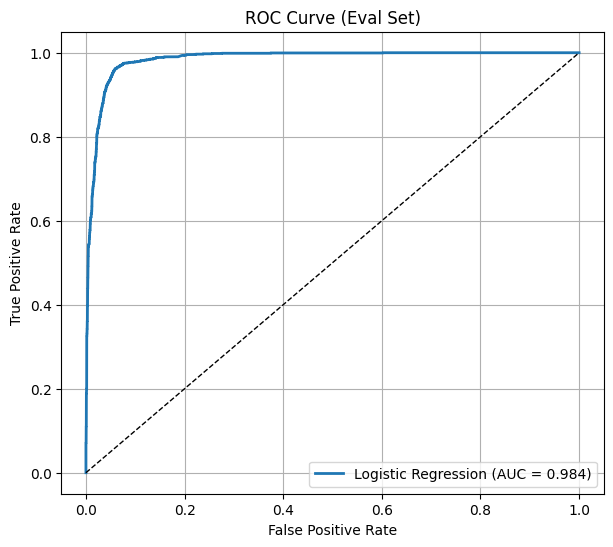

In [69]:
# ==========================================================
# ROC CURVE FOR EVAL SET
# ==========================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for class 1
y_prob_eval = log_reg.predict_proba(X_eval)[:, 1]

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_eval, y_prob_eval)

# Compute Area Under Curve
roc_auc = auc(fpr, tpr)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Eval Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# ==========================================================
# PREDICT ON TEST SET
# ==========================================================

# Predict class labels (0 or 1)
y_pred_test = log_reg.predict(X_test)

# Predict probabilities for class 1 (hate-speech)
y_prob_test = log_reg.predict_proba(X_test)[:, 1]

print("Test predictions ready.")

# show a few examples
for i in range(10):
    print(f"Tweet: {df_test['clean_tweet'].iloc[i]}")
    print(f"Predicted label: {y_pred_test[i]},  Probability: {y_prob_test[i]:.4f}")
    print("----")


Test predictions ready.
Tweet: studiolife aislife requires passion dedication willpower find newmaterials
Predicted label: 0,  Probability: 0.2423
----
Tweet: white supremacists want everyone see new birds movie heres
Predicted label: 1,  Probability: 0.5164
----
Tweet: safe ways heal acne altwaystoheal healthy healing
Predicted label: 0,  Probability: 0.0516
----
Tweet: hp cursed child book reservations already yes harrypotter pottermore favorite
Predicted label: 0,  Probability: 0.1568
----
Tweet: rd bihday amazing hilarious nephew eli ahmir uncle dave loves misses
Predicted label: 0,  Probability: 0.0061
----
Tweet: choose momtips
Predicted label: 0,  Probability: 0.0986
----
Tweet: something inside dies eyes ness smokeyeyes tired lonely sof grunge
Predicted label: 0,  Probability: 0.0240
----
Tweet: finishedtattooinkedinkloveit thanksaleeee
Predicted label: 0,  Probability: 0.2604
----
Tweet: never understand dad left young deep inthefeels
Predicted label: 0,  Probability: 0.1702
-

# SVM (LinearSVC)

In [ ]:
# ==========================================================
# LINEARSVC (SVM WITH LINEAR KERNEL)
# Trains on TF-IDF features (X_train, y_train from oversampling).
# ==========================================================

from sklearn.svm import LinearSVC

# create the model
svm_clf = LinearSVC(
    C=1.0,           # regularization strength (can tune later)
    max_iter=5000,   # allow more iterations to converge
)

# fit the model on oversampled training data
svm_clf.fit(X_train, y_train)

print("LinearSVC model trained.")



LinearSVC model trained.


In [83]:
# ==========================================================
# MULTINOMIAL NAIVE BAYES BASELINE
# ==========================================================

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# create the model
nb_clf = MultinomialNB()

# fit on oversampled training data
nb_clf.fit(X_train, y_train)

print("MultinomialNB model trained.")


MultinomialNB model trained.


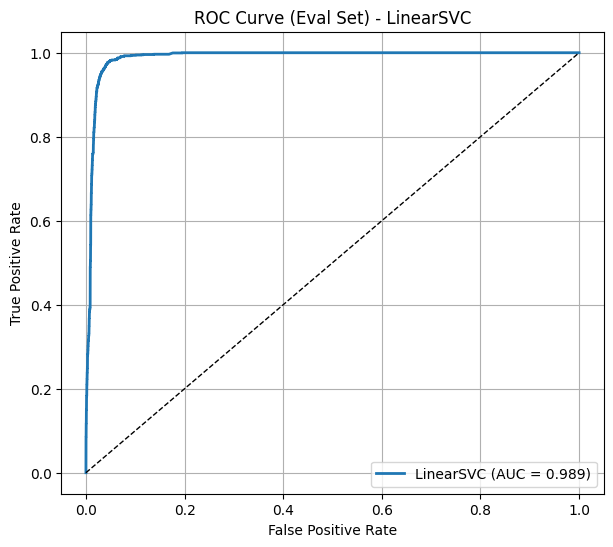

In [84]:
# ==========================================================
# ROC CURVE FOR EVAL SET (LINEARSVC)
# Uses decision_function scores since SVM has no predict_proba.
# ==========================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# decision scores for class 1
svm_scores_eval = svm_clf.decision_function(X_eval)

# compute ROC curve points
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_eval, svm_scores_eval)

# compute Area Under Curve
roc_auc_svm = auc(fpr_svm, tpr_svm)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7, 6))
plt.plot(fpr_svm, tpr_svm, label=f"LinearSVC (AUC = {roc_auc_svm:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Eval Set) - LinearSVC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [85]:
# ==========================================================
# PREDICT ON TEST SET (LINEARSVC)
# ==========================================================

# predicted class labels (0 or 1)
y_pred_test_svm = svm_clf.predict(X_test)

print("LinearSVC test predictions ready.")

# show a few examples
for i in range(10):
    print(f"Tweet: {df_test['clean_tweet'].iloc[i]}")
    print(f"Predicted label (LinearSVC): {y_pred_test_svm[i]}")
    print("----")


LinearSVC test predictions ready.
Tweet: studiolife aislife requires passion dedication willpower find newmaterials
Predicted label (LinearSVC): 0
----
Tweet: white supremacists want everyone see new birds movie heres
Predicted label (LinearSVC): 0
----
Tweet: safe ways heal acne altwaystoheal healthy healing
Predicted label (LinearSVC): 0
----
Tweet: hp cursed child book reservations already yes harrypotter pottermore favorite
Predicted label (LinearSVC): 0
----
Tweet: rd bihday amazing hilarious nephew eli ahmir uncle dave loves misses
Predicted label (LinearSVC): 0
----
Tweet: choose momtips
Predicted label (LinearSVC): 0
----
Tweet: something inside dies eyes ness smokeyeyes tired lonely sof grunge
Predicted label (LinearSVC): 0
----
Tweet: finishedtattooinkedinkloveit thanksaleeee
Predicted label (LinearSVC): 0
----
Tweet: never understand dad left young deep inthefeels
Predicted label (LinearSVC): 0
----
Tweet: delicious food lovelife capetown mannaepicure resturant
Predicted lab

# Naive Bayes (MultinomialNB)

In [86]:
# ==========================================================
# LINEARSVC BASELINE (SVM WITH LINEAR KERNEL)
# Trains on TF-IDF features (X_train, y_train from oversampling).
# ==========================================================

from sklearn.svm import LinearSVC

# create the model
svm_clf = LinearSVC(
    C=1.0,           # regularization strength (can tune later)
    max_iter=5000,   # allow more iterations to converge
)

# fit the model on oversampled training data
svm_clf.fit(X_train, y_train)

print("LinearSVC model trained.")




LinearSVC model trained.


In [87]:
# ==========================================================
# EVALUATE LINEARSVC ON EVAL SET
# ==========================================================

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# predict labels for the eval set
y_pred_eval_svm = svm_clf.predict(X_eval)

# accuracy
eval_acc_svm = accuracy_score(y_eval, y_pred_eval_svm)
print("Eval Accuracy (LinearSVC):", eval_acc_svm)

# confusion matrix
print("\nConfusion Matrix (Eval, LinearSVC):")
print(confusion_matrix(y_eval, y_pred_eval_svm))

# detailed metrics
print("\nClassification Report (Eval, LinearSVC):")
print(classification_report(y_eval, y_pred_eval_svm))


Eval Accuracy (LinearSVC): 0.9602979921867902

Confusion Matrix (Eval, LinearSVC):
[[5134  370]
 [  67 5436]]

Classification Report (Eval, LinearSVC):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5504
           1       0.94      0.99      0.96      5503

    accuracy                           0.96     11007
   macro avg       0.96      0.96      0.96     11007
weighted avg       0.96      0.96      0.96     11007



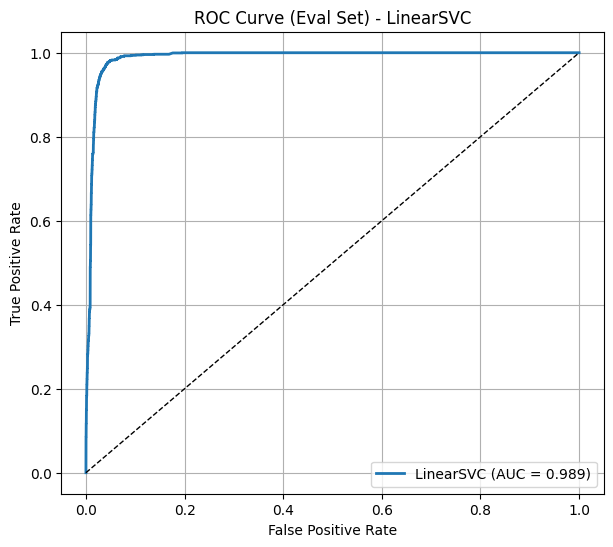

In [88]:
# ==========================================================
# ROC CURVE FOR EVAL SET (LINEARSVC)
# Uses decision_function scores since SVM has no predict_proba.
# ==========================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# decision scores for class 1
svm_scores_eval = svm_clf.decision_function(X_eval)

# compute ROC curve points
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_eval, svm_scores_eval)

# compute Area Under Curve
roc_auc_svm = auc(fpr_svm, tpr_svm)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(7, 6))
plt.plot(fpr_svm, tpr_svm, label=f"LinearSVC (AUC = {roc_auc_svm:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Eval Set) - LinearSVC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [89]:
# ==========================================================
# PREDICT ON TEST SET (MULTINOMIALNB)
# ==========================================================

# predicted class labels (0 or 1)
y_pred_test_nb = nb_clf.predict(X_test)

# predicted probabilities for class 1
y_prob_test_nb = nb_clf.predict_proba(X_test)[:, 1]

print("MultinomialNB test predictions ready.")

# show a few examples
for i in range(10):
    print(f"Tweet: {df_test['clean_tweet'].iloc[i]}")
    print(f"Predicted label (MultinomialNB): {y_pred_test_nb[i]},  Prob: {y_prob_test_nb[i]:.4f}")
    print("----")


MultinomialNB test predictions ready.
Tweet: studiolife aislife requires passion dedication willpower find newmaterials
Predicted label (MultinomialNB): 0,  Prob: 0.3565
----
Tweet: white supremacists want everyone see new birds movie heres
Predicted label (MultinomialNB): 0,  Prob: 0.2209
----
Tweet: safe ways heal acne altwaystoheal healthy healing
Predicted label (MultinomialNB): 0,  Prob: 0.0439
----
Tweet: hp cursed child book reservations already yes harrypotter pottermore favorite
Predicted label (MultinomialNB): 0,  Prob: 0.2231
----
Tweet: rd bihday amazing hilarious nephew eli ahmir uncle dave loves misses
Predicted label (MultinomialNB): 0,  Prob: 0.0127
----
Tweet: choose momtips
Predicted label (MultinomialNB): 0,  Prob: 0.3381
----
Tweet: something inside dies eyes ness smokeyeyes tired lonely sof grunge
Predicted label (MultinomialNB): 0,  Prob: 0.0303
----
Tweet: finishedtattooinkedinkloveit thanksaleeee
Predicted label (MultinomialNB): 1,  Prob: 0.5000
----
Tweet: neve

# Random Forest

In [90]:
# ==========================================================
# RANDOM FOREST BASELINE
# Note: Can be slower and heavier on TF-IDF (sparse, high-dim).
# We keep a moderate number of trees.
# ==========================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# create the model
rf_clf = RandomForestClassifier(
    n_estimators=200,      # number of trees (can tune)
    max_depth=None,       # let trees grow fully (or set e.g. 20)
    n_jobs=-1,            # use all CPU cores
    random_state=42
)

# fit on oversampled training data
rf_clf.fit(X_train, y_train)

print("RandomForest model trained.")


RandomForest model trained.


In [91]:
# ==========================================================
# EVALUATE RANDOMFOREST ON EVAL SET
# ==========================================================

# predict labels for the eval set
y_pred_eval_rf = rf_clf.predict(X_eval)

# accuracy
eval_acc_rf = accuracy_score(y_eval, y_pred_eval_rf)
print("Eval Accuracy (RandomForest):", eval_acc_rf)

# confusion matrix
print("\nConfusion Matrix (Eval, RandomForest):")
print(confusion_matrix(y_eval, y_pred_eval_rf))

# detailed metrics
print("\nClassification Report (Eval, RandomForest):")
print(classification_report(y_eval, y_pred_eval_rf))


Eval Accuracy (RandomForest): 0.9855546470427909

Confusion Matrix (Eval, RandomForest):
[[5362  142]
 [  17 5486]]

Classification Report (Eval, RandomForest):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5504
           1       0.97      1.00      0.99      5503

    accuracy                           0.99     11007
   macro avg       0.99      0.99      0.99     11007
weighted avg       0.99      0.99      0.99     11007



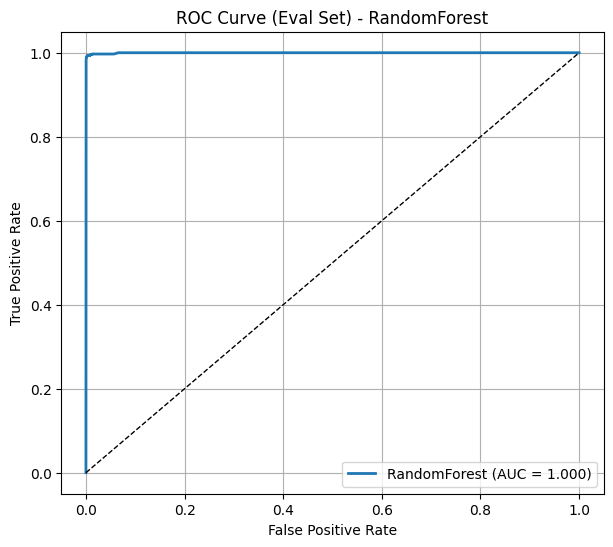

In [92]:
# ==========================================================
# ROC CURVE FOR EVAL SET (RANDOMFOREST)
# Uses predict_proba for class 1.
# ==========================================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# probabilities for class 1
y_prob_eval_rf = rf_clf.predict_proba(X_eval)[:, 1]

# compute ROC curve points
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_eval, y_prob_eval_rf)

# compute AUC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# plot
plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC = {roc_auc_rf:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Eval Set) - RandomForest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [93]:
# ==========================================================
# PREDICT ON TEST SET (RANDOMFOREST)
# ==========================================================

# predicted class labels (0 or 1)
y_pred_test_rf = rf_clf.predict(X_test)

# predicted probabilities for class 1
y_prob_test_rf = rf_clf.predict_proba(X_test)[:, 1]

print("RandomForest test predictions ready.")

# show a few examples
for i in range(10):
    print(f"Tweet: {df_test['clean_tweet'].iloc[i]}")
    print(f"Predicted label (RandomForest): {y_pred_test_rf[i]},  Prob: {y_prob_test_rf[i]:.4f}")
    print("----")


RandomForest test predictions ready.
Tweet: studiolife aislife requires passion dedication willpower find newmaterials
Predicted label (RandomForest): 0,  Prob: 0.0515
----
Tweet: white supremacists want everyone see new birds movie heres
Predicted label (RandomForest): 1,  Prob: 0.5750
----
Tweet: safe ways heal acne altwaystoheal healthy healing
Predicted label (RandomForest): 0,  Prob: 0.0000
----
Tweet: hp cursed child book reservations already yes harrypotter pottermore favorite
Predicted label (RandomForest): 0,  Prob: 0.0300
----
Tweet: rd bihday amazing hilarious nephew eli ahmir uncle dave loves misses
Predicted label (RandomForest): 0,  Prob: 0.0000
----
Tweet: choose momtips
Predicted label (RandomForest): 0,  Prob: 0.0558
----
Tweet: something inside dies eyes ness smokeyeyes tired lonely sof grunge
Predicted label (RandomForest): 0,  Prob: 0.0201
----
Tweet: finishedtattooinkedinkloveit thanksaleeee
Predicted label (RandomForest): 0,  Prob: 0.3379
----
Tweet: never underst

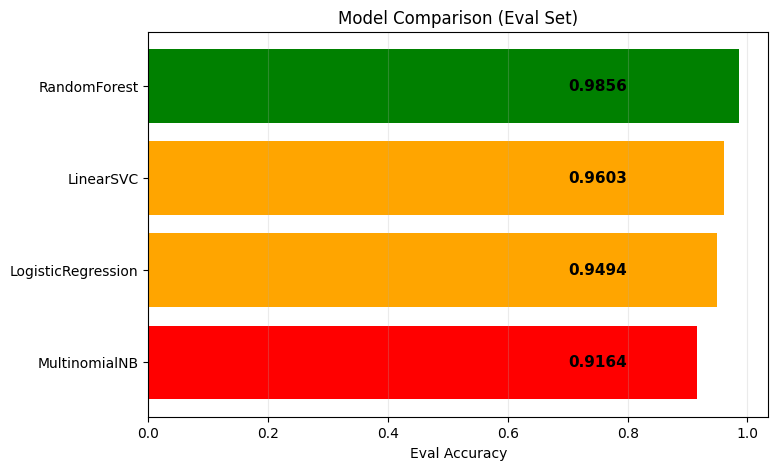

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# dictionary of trained models
models = {
    "LogisticRegression": log_reg,
    "LinearSVC": svm_clf,
    "MultinomialNB": nb_clf,
    "RandomForest": rf_clf
}

# calculate accuracies
results = []
for name, clf in models.items():
    acc = accuracy_score(y_eval, clf.predict(X_eval))
    results.append((name, acc))

# sort descending by accuracy
results.sort(key=lambda x: x[1], reverse=True)

model_names = [x[0] for x in results]
accuracies = [x[1] for x in results]

# assign colors by rank
colors = []
for i in range(len(results)):
    if i == 0:
        colors.append("green")     # best
    elif i == len(results) - 1:
        colors.append("red")       # worst
    else:
        colors.append("orange")    # middle

# -------------------------
# Plot horizontal bars
# -------------------------
plt.figure(figsize=(8, 5))
y_pos = np.arange(len(model_names))

bars = plt.barh(y_pos, accuracies, color=colors)
plt.yticks(y_pos, model_names)
plt.xlabel("Eval Accuracy")
plt.title("Model Comparison (Eval Set)")
plt.gca().invert_yaxis()  # highest accuracy at top
plt.grid(axis='x', alpha=0.25)

# -------------------------
# Put accuracy text INSIDE bars
# -------------------------
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(
        0.75,                 # middle of bar horizontally
        bar.get_y() + bar.get_height() / 2,  # vertical center
        f"{accuracies[i]:.4f}",
        ha='center', va='center', 
        color='black', fontsize=11, fontweight='bold'
    )

plt.show()
